# Support files

In [ ]:
print(df.info())  # Check column data types
print(df.head())  # View first few rows


# Main

In [2]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


Feature Extraction

In [ ]:
# Load the dataset
data_path = "/content/pd_speech_features.csv"  # Change this to your file path
df = pd.read_csv(data_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print(df.head())


In [ ]:
df = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, set errors as NaN
df = df.dropna()  # Remove rows with NaN values

print(df.shape)  # Check the cleaned dataset


(756, 755)


In [ ]:
print(df.head())

In [ ]:
# Extract features (excluding patient ID & class column)
X = df.iloc[:, 2:-1]  # Columns 3 to 754 (speech features)
y = df.iloc[:, -1]    # Class column (0 = Healthy, 1 = PD)

# Normalize data
scaler = MinMaxScaler()  # StandardScaler() can also be used
X_scaled = scaler.fit_transform(X)

print("Feature Matrix Shape:", X_scaled.shape)


Feature Matrix Shape: (756, 752)


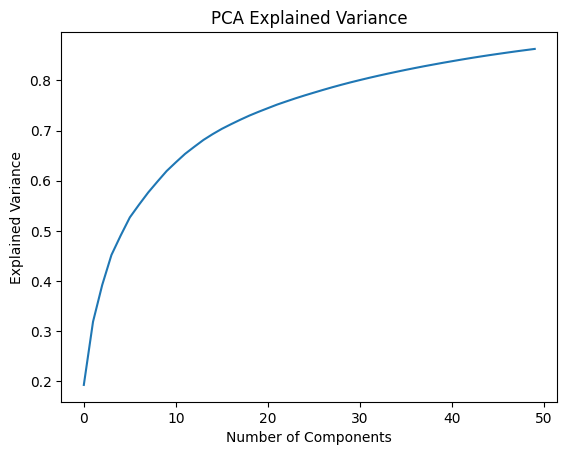

Reduced Feature Shape (PCA): (756, 50)


In [ ]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)  # Keep top 50 components
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

print("Reduced Feature Shape (PCA):", X_pca.shape)


In [ ]:
# Split data into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

print("Train Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)


Train Set Shape: (604, 50)
Test Set Shape: (152, 50)


In [ ]:
# Define models
models = {
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Train & Evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict test set
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for AUC-ROC

    # Print model performance
    print(f"\n🔥 {name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print(classification_report(y_test, y_pred))



🔥 SVM Model Performance:
Accuracy: 0.8224
AUC-ROC: 0.9353
              precision    recall  f1-score   support

         0.0       0.80      0.41      0.54        39
         1.0       0.83      0.96      0.89       113

    accuracy                           0.82       152
   macro avg       0.81      0.69      0.72       152
weighted avg       0.82      0.82      0.80       152


🔥 Random Forest Model Performance:
Accuracy: 0.8224
AUC-ROC: 0.8892
              precision    recall  f1-score   support

         0.0       0.80      0.41      0.54        39
         1.0       0.83      0.96      0.89       113

    accuracy                           0.82       152
   macro avg       0.81      0.69      0.72       152
weighted avg       0.82      0.82      0.80       152



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:17:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔥 XGBoost Model Performance:
Accuracy: 0.8816
AUC-ROC: 0.9242
              precision    recall  f1-score   support

         0.0       0.86      0.64      0.74        39
         1.0       0.89      0.96      0.92       113

    accuracy                           0.88       152
   macro avg       0.87      0.80      0.83       152
weighted avg       0.88      0.88      0.88       152



Grid search

In [ ]:
# SVM Hyperparameters
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Random Forest Hyperparameters
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

# XGBoost Hyperparameters
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}


In [ ]:
# Define models
svm = SVC(probability=True, random_state=42)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Grid Search for SVM
svm_grid = GridSearchCV(svm, svm_params, cv=5, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

# Grid Search for Random Forest
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Grid Search for XGBoost
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:24:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [ ]:
# Best hyperparameters
print("\n🔥 Best SVM Parameters:", svm_grid.best_params_)
print("🔥 Best Random Forest Parameters:", rf_grid.best_params_)
print("🔥 Best XGBoost Parameters:", xgb_grid.best_params_)

# Evaluate Best Models
models = {
    "SVM": svm_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # For AUC-ROC

    print(f"\n🔥 {name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.4f}")
    print(classification_report(y_test, y_pred))



🔥 Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
🔥 Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
🔥 Best XGBoost Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}

🔥 SVM Model Performance:
Accuracy: 0.9408
AUC-ROC: 0.9816
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88        39
         1.0       0.95      0.97      0.96       113

    accuracy                           0.94       152
   macro avg       0.93      0.91      0.92       152
weighted avg       0.94      0.94      0.94       152


🔥 Random Forest Model Performance:
Accuracy: 0.8289
AUC-ROC: 0.8901
              precision    recall  f1-score   support

         0.0       0.81      0.44      0.57        39
         1.0       0.83      0.96      0.89       113

    accuracy                           0.83       152
   macro avg       0.82      0.70      0.73       152
weighted avg       0

In [ ]:

row_index = 5  # Choose any patient index
feature_row = df.iloc[row_index, :-1].values  # Drop the label column

# Normalize the feature values (important for spectrogram generation)
feature_row = (feature_row - np.min(feature_row)) / (np.max(feature_row) - np.min(feature_row))

print("Selected Row Shape:", feature_row.shape)  # Expected shape: (754,)


Selected Row Shape: (754,)


In [ ]:
# Define parameters for Mel Spectrogram
sample_rate = 16000  # Assume a standard speech sample rate
n_fft = 1024  # FFT window size
hop_length = 512  # Hop length for overlapping windows

# Generate Mel Spectrogram from the row data (treated as a pseudo-signal)
mel_spec = librosa.feature.melspectrogram(y=feature_row, sr=sample_rate, n_mels=128, fmax=8000)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=754
  warnings.warn(


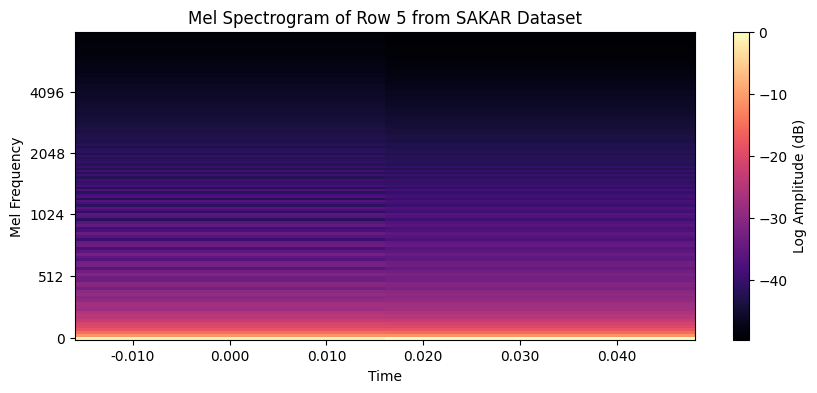

In [ ]:
# Plot the Mel Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis="mel")
plt.colorbar(label="Log Amplitude (dB)")
plt.title(f"Mel Spectrogram of Row {row_index} from SAKAR Dataset")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()


In [ ]:
df = df.iloc[:,2:]

In [1]:

# Compute Correlation with Class Label
correlation_matrix = df_selected.corr()

# Select the Top 20 Most Correlated Features (Positive or Negative)
top_features = correlation_matrix["class"].abs().sort_values(ascending=False).head(20).index

# Filter the correlation matrix for these top features
top_corr_matrix = correlation_matrix.loc[top_features, top_features]

# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🔥 Heatmap of Top Features Correlated with Class Label")
plt.show()

NameError: name 'df_selected' is not defined

In [ ]:
df.columns

Index(['PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       'locAbsJitter', 'rapJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=753)